/home/jivnesh/anaconda3/envs/RishiSurge/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded DataFrame with 60000 rows.
Taking a random sample of 1000 rows.

--- Starting Evaluation ---
Initializing Binoculars...
Loading observer model: tiiuae/falcon-7b onto cuda:0




Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


Loading performer model: tiiuae/falcon-7b-instruct onto cuda:1




Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.94s/it]


Binoculars initialized successfully.

Running predictions on 1000 samples in batches of 8...


Processing Batches: 100%|██████████| 125/125 [42:16<00:00, 20.29s/it]


Predictions complete.

--- Evaluation Results ---
Accuracy on 1000 samples: 82.10% (821/1000 correct)

--- Advanced Metrics ---
ROC AUC Score: 0.9235
False Positive Rate (FPR): 0.1311 (Rate of human text incorrectly flagged as AI)

Confusion Matrix plot saved as 'confusion_matrix.png'


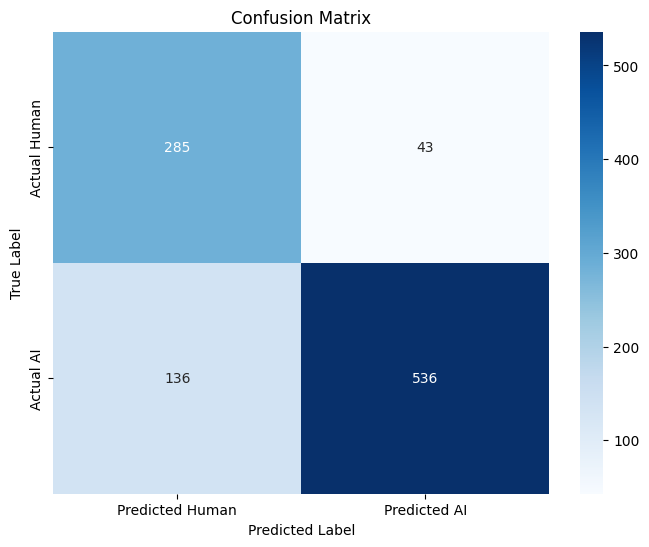

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
from typing import Union, List
from tqdm import tqdm

# New imports for advanced metrics and plotting
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Pre-computation Setup & Warnings ---
torch.set_grad_enabled(False)

# --- Metric Functions (Unchanged) ---
ce_loss_fn = torch.nn.CrossEntropyLoss(reduction="none")
softmax_fn = torch.nn.Softmax(dim=-1)

def perplexity(encoding: transformers.BatchEncoding, logits: torch.Tensor, median: bool = False, temperature: float = 1.0):
    shifted_logits = logits[..., :-1, :].contiguous() / temperature
    shifted_labels = encoding.input_ids[..., 1:].contiguous()
    shifted_attention_mask = encoding.attention_mask[..., 1:].contiguous()
    if median:
        ce_nan = (ce_loss_fn(shifted_logits.transpose(1, 2), shifted_labels).masked_fill(~shifted_attention_mask.bool(), float("nan")))
        ppl = np.nanmedian(ce_nan.cpu().float().numpy(), 1)
    else:
        ppl = (ce_loss_fn(shifted_logits.transpose(1, 2), shifted_labels) * shifted_attention_mask).sum(1) / shifted_attention_mask.sum(1)
        ppl = ppl.to("cpu").float().numpy()
    return ppl

def entropy(p_logits: torch.Tensor, q_logits: torch.Tensor, encoding: transformers.BatchEncoding, pad_token_id: int, median: bool = False, sample_p: bool = False, temperature: float = 1.0):
    vocab_size = p_logits.shape[-1]
    total_tokens_available = q_logits.shape[-2]
    p_scores, q_scores = p_logits / temperature, q_logits / temperature
    p_proba = softmax_fn(p_scores).view(-1, vocab_size)
    if sample_p:
        p_proba = torch.multinomial(p_proba.view(-1, vocab_size), replacement=True, num_samples=1).view(-1)
    q_scores = q_scores.view(-1, vocab_size)
    ce = ce_loss_fn(input=q_scores, target=p_proba).view(-1, total_tokens_available)
    padding_mask = (encoding.input_ids != pad_token_id).type(torch.uint8)
    if median:
        ce_nan = ce.masked_fill(~padding_mask.bool(), float("nan"))
        agg_ce = np.nanmedian(ce_nan.cpu().float().numpy(), 1)
    else:
        agg_ce = (((ce * padding_mask).sum(1) / padding_mask.sum(1)).to("cpu").float().numpy())
    return agg_ce

# --- Binoculars Classifier (Unchanged) ---
huggingface_config = {"TOKEN": os.environ.get("HF_TOKEN", None)}
BINOCULARS_ACCURACY_THRESHOLD = 0.9015310749276843
BINOCULARS_FPR_THRESHOLD = 0.8536432310785527
DEVICE_1 = "cuda:0" if torch.cuda.is_available() else "cpu"
DEVICE_2 = "cuda:1" if torch.cuda.device_count() > 1 else DEVICE_1

class Binoculars(object):
    def __init__(self, observer_name_or_path: str = "tiiuae/falcon-7b", performer_name_or_path: str = "tiiuae/falcon-7b-instruct", use_bfloat16: bool = True, max_token_observed: int = 512, mode: str = "low-fpr") -> None:
        print("Initializing Binoculars...")
        if observer_name_or_path != performer_name_or_path: print(f"Warning: Using different models ({observer_name_or_path}, {performer_name_or_path}). Make sure their tokenizers are compatible.")
        self.change_mode(mode)
        print(f"Loading observer model: {observer_name_or_path} onto {DEVICE_1}")
        self.observer_model = AutoModelForCausalLM.from_pretrained(observer_name_or_path, device_map={"": DEVICE_1}, trust_remote_code=True, torch_dtype=torch.bfloat16 if use_bfloat16 else torch.float32, token=huggingface_config["TOKEN"])
        print(f"Loading performer model: {performer_name_or_path} onto {DEVICE_2}")
        self.performer_model = AutoModelForCausalLM.from_pretrained(performer_name_or_path, device_map={"": DEVICE_2}, trust_remote_code=True, torch_dtype=torch.bfloat16 if use_bfloat16 else torch.float32, token=huggingface_config["TOKEN"])
        self.observer_model.eval(); self.performer_model.eval()
        self.tokenizer = AutoTokenizer.from_pretrained(observer_name_or_path, token=huggingface_config["TOKEN"])
        if not self.tokenizer.pad_token: self.tokenizer.pad_token = self.tokenizer.eos_token
        self.max_token_observed = max_token_observed
        print("Binoculars initialized successfully.")
    def change_mode(self, mode: str) -> None:
        if mode == "low-fpr": self.threshold = BINOCULARS_FPR_THRESHOLD
        elif mode == "accuracy": self.threshold = BINOCULARS_ACCURACY_THRESHOLD
        else: raise ValueError(f"Invalid mode: {mode}")
    def _tokenize(self, batch: list[str]) -> transformers.BatchEncoding:
        return self.tokenizer(batch, return_tensors="pt", padding="longest", truncation=True, max_length=self.max_token_observed, return_token_type_ids=False)
    @torch.inference_mode()
    def _get_logits(self, encodings: transformers.BatchEncoding) -> tuple[torch.Tensor, torch.Tensor]:
        observer_logits = self.observer_model(**encodings.to(DEVICE_1)).logits
        performer_logits = self.performer_model(**encodings.to(DEVICE_2)).logits
        if torch.cuda.is_available() and DEVICE_1 != "cpu": torch.cuda.synchronize()
        return observer_logits, performer_logits
    def compute_score(self, input_text: Union[str, List[str]]) -> Union[float, List[float]]:
        batch = [input_text] if isinstance(input_text, str) else input_text
        encodings = self._tokenize(batch)
        observer_logits, performer_logits = self._get_logits(encodings)
        ppl_val = perplexity(encodings.to(DEVICE_2), performer_logits)
        x_ppl_val = entropy(observer_logits.to(DEVICE_1), performer_logits.to(DEVICE_1), encodings.to(DEVICE_1), self.tokenizer.pad_token_id)
        binoculars_scores = ppl_val / x_ppl_val
        return binoculars_scores.tolist()[0] if isinstance(input_text, str) else binoculars_scores.tolist()
    def predict(self, input_text: Union[str, List[str]]) -> Union[str, List[str]]:
        binoculars_scores = np.array(self.compute_score(input_text))
        pred = np.where(binoculars_scores < self.threshold, "AI-generated", "Human-generated").tolist()
        return pred

# --- MODIFIED: Evaluation with Advanced Metrics ---

def evaluate_on_dataframe(df: pd.DataFrame, batch_size: int = 16):
    print("\n--- Starting Evaluation ---")
    try:
        binoculars = Binoculars(mode="accuracy")
    except Exception as e:
        print(f"\n--- ERROR ---"); print(f"Failed to initialize Binoculars classifier: {e}"); return

    text_samples = df["text"].tolist()
    true_labels = df["models"].tolist()
    all_predictions, all_scores = [], []

    print(f"\nRunning predictions on {len(text_samples)} samples in batches of {batch_size}...")
    for i in tqdm(range(0, len(text_samples), batch_size), desc="Processing Batches"):
        batch_texts = text_samples[i:i + batch_size]
        batch_scores = binoculars.compute_score(batch_texts)
        batch_predictions = np.where(np.array(batch_scores) < binoculars.threshold, "AI-generated", "Human-generated").tolist()
        all_predictions.extend(batch_predictions); all_scores.extend(batch_scores)
    print("Predictions complete.")

    results_df = pd.DataFrame({'text': text_samples, 'true_label': ["AI-generated" if l == 'ai' else "Human-generated" for l in true_labels], 'predicted_label': all_predictions, 'binoculars_score': all_scores})
    correct_predictions = (results_df['true_label'] == results_df['predicted_label']).sum()
    total_predictions = len(results_df)
    accuracy = correct_predictions / total_predictions

    print("\n--- Evaluation Results ---")
    print(f"Accuracy on {total_predictions} samples: {accuracy:.2%} ({correct_predictions}/{total_predictions} correct)")
    
    # --- NEW: Advanced Metrics Calculation ---
    print("\n--- Advanced Metrics ---")
    
    # 1. Prepare data for scikit-learn: Convert string labels to binary (0 or 1)
    #    Positive class (1): 'AI-generated'
    #    Negative class (0): 'Human-generated'
    y_true = (results_df['true_label'] == 'AI-generated').astype(int)
    y_pred = (results_df['predicted_label'] == 'AI-generated').astype(int)

    # For ROC AUC, we need scores. A lower binoculars_score indicates a higher
    # probability of being AI-generated. We can use the negative of the score
    # so that higher values correspond to the positive (AI) class.
    y_scores = -results_df['binoculars_score'].values

    # 2. Calculate ROC AUC Score
    try:
        auc_score = roc_auc_score(y_true, y_scores)
        print(f"ROC AUC Score: {auc_score:.4f}")
    except ValueError as e:
        print(f"Could not calculate ROC AUC Score: {e}")

    # 3. Calculate Confusion Matrix and False Positive Rate (FPR)
    try:
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        # Calculate FPR = False Positives / (False Positives + True Negatives)
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        print(f"False Positive Rate (FPR): {fpr:.4f} (Rate of human text incorrectly flagged as AI)")

        # Plot Confusion Matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Predicted Human', 'Predicted AI'],
                    yticklabels=['Actual Human', 'Actual AI'])
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig('confusion_matrix.png')
        print("\nConfusion Matrix plot saved as 'confusion_matrix.png'")
        
    except ValueError as e:
        print(f"Could not calculate Confusion Matrix or FPR: {e}")

if __name__ == '__main__':
    try:
        full_df = pd.read_csv('/home/jivnesh/Rishi_Surge/data_1.csv') 
    except FileNotFoundError:
        print("--- MOCK DATA ---"); print("File 'your_data.csv' not found. Creating a mock DataFrame for demonstration.")
        mock_data = {'models': ['human', 'ai'] * 500, 'text': [f"This is sample text number {i}." for i in range(1000)]}
        full_df = pd.DataFrame(mock_data)
    print(f"Loaded DataFrame with {len(full_df)} rows.")

    if len(full_df) < 1000:
        sample_df = full_df
    else:
        print("Taking a random sample of 1000 rows.")
        sample_df = full_df.sample(n=1000, random_state=38)

    evaluate_on_dataframe(sample_df, batch_size=8)

In [1]:
import os
import time
import torch
import pandas as pd
import numpy as np
from scipy.stats import norm
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score
from sklearn.utils import shuffle
from transformers import AutoModelForCausalLM, AutoTokenizer

# A dictionary to map short names to Hugging Face model identifiers
model_fullnames = {
    'gemma3-4b': 'google/gemma-3-4b-it', # Use instruct-tuned version for better performance
}

def get_model_fullname(model_name):
    return model_fullnames.get(model_name, model_name)

def load_model(model_name, device, cache_dir, quantization=None):
    model_fullname = get_model_fullname(model_name)
    print(f'Loading model {model_fullname}...')
    model_kwargs = {"cache_dir": cache_dir}
    print("-> Loading model in bfloat16 (half-precision)...")
    model_kwargs["torch_dtype"] = torch.bfloat16
    model_kwargs["device_map"] = "auto"
    model = AutoModelForCausalLM.from_pretrained(model_fullname, **model_kwargs)
    model.eval()
    return model

def load_tokenizer(model_name, cache_dir):
    model_fullname = get_model_fullname(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_fullname, cache_dir=cache_dir)
    if tokenizer.pad_token_id is None:
        tokenizer.pad_token_id = tokenizer.eos_token_id
    return tokenizer

def get_sampling_discrepancy_analytic(logits_ref, logits_score, labels):
    if logits_ref.size(-1) != logits_score.size(-1):
        vocab_size = min(logits_ref.size(-1), logits_score.size(-1))
        logits_ref = logits_ref[:, :, :vocab_size]
        logits_score = logits_score[:, :, :vocab_size]
    labels = labels.unsqueeze(-1) if labels.ndim == logits_score.ndim - 1 else labels
    lprobs_score = torch.log_softmax(logits_score, dim=-1)
    probs_ref = torch.softmax(logits_ref, dim=-1)
    log_likelihood = lprobs_score.gather(dim=-1, index=labels).squeeze(-1)
    mean_ref = (probs_ref * lprobs_score).sum(dim=-1)
    var_ref = (probs_ref * torch.square(lprobs_score)).sum(dim=-1) - torch.square(mean_ref)
    log_likelihood_sum = log_likelihood.sum(dim=-1)
    mean_ref_sum = mean_ref.sum(dim=-1)
    var_ref_sum = var_ref.sum(dim=-1)
    denominator = torch.sqrt(torch.relu(var_ref_sum)) + 1e-6
    discrepancy = (log_likelihood_sum - mean_ref_sum) / denominator
    return discrepancy.item()

def compute_prob_norm(x, mu0, sigma0, mu1, sigma1):
    pdf_value0 = norm.pdf(x, loc=mu0, scale=sigma0)
    pdf_value1 = norm.pdf(x, loc=mu1, scale=sigma1)
    prob = pdf_value1 / (pdf_value0 + pdf_value1 + 1e-6)
    return prob

class FastDetectGPTDetector:
    def __init__(self, scoring_model_name, sampling_model_name, device, cache_dir, quantization):
        self.scoring_model_name = scoring_model_name
        self.sampling_model_name = sampling_model_name
        self.scoring_tokenizer = load_tokenizer(scoring_model_name, cache_dir)
        self.scoring_model = load_model(scoring_model_name, device, cache_dir, quantization)
        if sampling_model_name == scoring_model_name:
            self.sampling_model = self.scoring_model
            self.sampling_tokenizer = self.scoring_tokenizer
        else:
            self.sampling_tokenizer = load_tokenizer(sampling_model_name, cache_dir)
            self.sampling_model = load_model(sampling_model_name, device, cache_dir, quantization)
        # Using pre-calibrated parameters
        self.classifier_params = {'mu0': -0.0707, 'sigma0': 0.9520, 'mu1': 2.9306, 'sigma1': 1.9039}

    def compute_prob(self, text):
        tokenized_score = self.scoring_tokenizer(text, truncation=True, return_tensors="pt", max_length=1024)
        labels = tokenized_score.input_ids[:, 1:].to(self.scoring_model.device)
        if labels.shape[1] == 0:
            return 0.0
        with torch.no_grad():
            inputs_score = {k: v.to(self.scoring_model.device) for k, v in tokenized_score.items()}
            logits_score = self.scoring_model(**inputs_score).logits[:, :-1]
            if self.sampling_model_name == self.scoring_model_name:
                logits_ref = logits_score
            else:
                tokenized_ref = self.sampling_tokenizer(text, truncation=True, return_tensors="pt", max_length=1024)
                inputs_ref = {k: v.to(self.sampling_model.device) for k, v in tokenized_ref.items()}
                logits_ref = self.sampling_model(**inputs_ref).logits[:, :-1]
        crit = get_sampling_discrepancy_analytic(logits_ref, logits_score, labels)
        prob = compute_prob_norm(crit, **self.classifier_params)
        return prob

# --- Script Configuration ---
SCORING_MODEL_NAME = "gemma3-4b"
SAMPLING_MODEL_NAME = "gemma3-4b" # Use the same model for simplicity
DEVICE = "cuda:03" if torch.cuda.is_available() else "cpu"
CACHE_DIR = "./model_cache"
OUTPUT_FILE = "fastdetectgpt_gemma_results.csv"

# --- Main Execution ---
print("--- Initializing Fast-DetectGPT Detector ---")
detector = FastDetectGPTDetector(
    scoring_model_name=SCORING_MODEL_NAME,
    sampling_model_name=SAMPLING_MODEL_NAME,
    device=DEVICE,
    cache_dir=CACHE_DIR,
    quantization=None
)

print("\n--- Loading and preparing dataset ---")
try:
    df = pd.read_csv("/home/jivnesh/Harshit_Surge/dataset/sampled_train.csv")
except FileNotFoundError:
    print("Error: File '/home/jivnesh/Harshit_Surge/dataset/sampled_train.csv' not found.")
    exit()

data = pd.DataFrame()
data["models"] = df["model"].apply(lambda x: "ai" if x != "human" else "human")
data['text'] = df['title'] + " " + df['generation']
data.dropna(subset=['text'], inplace=True)

df_human = data[data.models == "human"]
df_ai = data[data.models == "ai"]

train_human = df_human.sample(n=10000, random_state=42)
train_ai = df_ai.sample(n=10000, random_state=42)
test_human = df_human.drop(train_human.index).sample(n=2000, random_state=42)
test_ai = df_ai.drop(train_ai.index).sample(n=2000, random_state=42)

test_df = pd.concat([test_human, test_ai], axis=0)
test_df = shuffle(test_df, random_state=42).reset_index(drop=True)

print(f"Test DataFrame created with {len(test_df)} samples.")
print("-" * 50)

print(f"\n--- Running detection on {len(test_df)} samples ---")
all_probs = []
true_labels = []

for index, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Processing samples"):
    try:
        prob = detector.compute_prob(row['text'])
        all_probs.append(prob)
        true_labels.append(0 if row['models'] == 'human' else 1)
    except Exception as e:
        print(f"Error processing sample (index {index}): {e}. Skipping.")
        continue

# --- Evaluating Results ---
print("\n" + "="*50)
print("      Fast-DetectGPT Classification Statistics")
print("="*50)

if len(all_probs) > 0 and len(set(true_labels)) > 1:
    # Convert probabilities to binary predictions for classification report
    binary_predictions = [1 if p > 0.5 else 0 for p in all_probs]

    # 1. Classification Report (Precision, Recall, F1-Score)
    print("\n--- Classification Report ---")
    print(classification_report(true_labels, binary_predictions, target_names=['Human', 'AI']))

    # 2. Overall Accuracy
    accuracy = accuracy_score(true_labels, binary_predictions)
    print(f"\nOverall Accuracy: {accuracy:.4f}")

    # 3. ROC AUC Score
    roc_auc = roc_auc_score(true_labels, all_probs)
    print(f"ROC AUC Score: {roc_auc:.4f}")

    # 4. Confusion Matrix and FPR
    cm = confusion_matrix(true_labels, binary_predictions)
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0

    print("\n--- Confusion Matrix ---")
    print(f"{'':<15} | {'Predicted Human':<15} | {'Predicted AI':<15}")
    print("-" * 50)
    print(f"{'Actual Human':<15} | {tn:<15} | {fp:<15}")
    print(f"{'Actual AI':<15} | {fn:<15} | {tp:<15}")
    print("-" * 50)
    print(f"\nFalse Positive Rate (FPR): {fpr:.4f} (Human text incorrectly flagged as AI)")
    print("\n" + "="*50)

    results_df = pd.DataFrame({'true_label': true_labels, 'predicted_prob_ai': all_probs})
    results_df.to_csv(OUTPUT_FILE, index=False)
    print(f"Detailed results saved to {OUTPUT_FILE}")
else:
    print(f"Could not compute metrics. Processed {len(all_probs)} samples.")

/home/jivnesh/anaconda3/envs/RishiSurge/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Initializing Fast-DetectGPT Detector ---
Loading model google/gemma-3-4b-it...
-> Loading model in bfloat16 (half-precision)...


2025-07-15 06:02:47.632017: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-15 06:02:47.655988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752526967.683718 2878913 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752526967.691376 2878913 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752526967.709566 2878913 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 


--- Loading and preparing dataset ---
Test DataFrame created with 4000 samples.
--------------------------------------------------

--- Running detection on 4000 samples ---


Processing samples: 100%|██████████| 4000/4000 [44:07<00:00,  1.51it/s] 


      Fast-DetectGPT Classification Statistics

--- Classification Report ---
              precision    recall  f1-score   support

       Human       0.50      1.00      0.67      2000
          AI       0.89      0.02      0.04      2000

    accuracy                           0.51      4000
   macro avg       0.70      0.51      0.35      4000
weighted avg       0.70      0.51      0.35      4000


Overall Accuracy: 0.5088
ROC AUC Score: 0.5670

--- Confusion Matrix ---
                | Predicted Human | Predicted AI   
--------------------------------------------------
Actual Human    | 1995            | 5              
Actual AI       | 1960            | 40             
--------------------------------------------------

False Positive Rate (FPR): 0.0025 (Human text incorrectly flagged as AI)

Detailed results saved to fastdetectgpt_gemma_results.csv


In [8]:
torch.cuda.empty_cache()